In [117]:
import time
import scipy.io
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data.dataloader import DataLoader
from torch.autograd import Variable

In [2]:
mnist = scipy.io.loadmat('mnist_all.mat')

mnist

In [4]:
%matplotlib inline

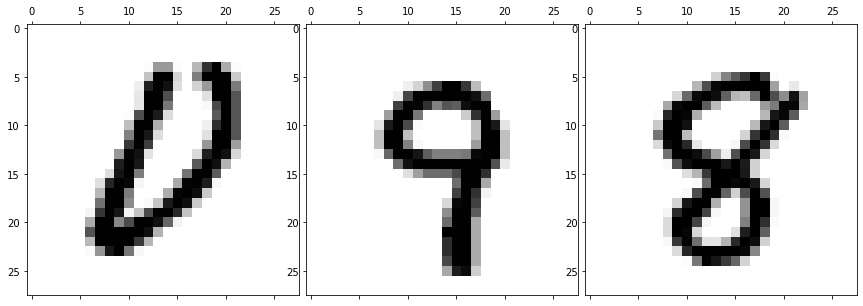

In [118]:
fig, ax = plt.subplots(1, 3, figsize = (15, 5))

ax[0].matshow(mnist['train0'][random.randint(0,1000)].reshape(28,28), cmap=plt.cm.gray_r)
ax[1].matshow(mnist['train9'][109].reshape(28,28), cmap=plt.cm.gray_r)
ax[2].matshow(mnist['train8'][200].reshape(28,28), cmap=plt.cm.gray_r)
plt.subplots_adjust(wspace = 0, hspace = 0) #odleglosc obrazkow od siebie

In [77]:
def parse_mnist(filename = 'mnist_all.mat', n_cut_train = 1000, n_cut_test = 500, transform = True):
    file = scipy.io.loadmat(filename)
    
    train_data = np.zeros((10, n_cut_train, 784))
    train_label = np.zeros((10, n_cut_train))
    test_data = np.zeros((10, n_cut_test, 784))
    test_label = np.zeros((10, n_cut_test))
    
    for i in range(10):
        name_train = 'train' + str(i)
        name_test = 'test' + str(i)
        train_data[i] = file[name_train][:n_cut_train]
        train_label[i].fill(i)   
        test_data[i] = file[name_test][:n_cut_test]
        test_label[i].fill(i)

    train_data = train_data.reshape(-1, 784)
    train_label = train_label.reshape(-1)
    test_data = test_data.reshape(-1, 784)
    test_label = test_label.reshape(-1)

    if transform:
        train_data = train_data/255.0
        test_data = test_data/255.0
        
    train_data = list(zip(torch.from_numpy(np.float32(train_data)), torch.from_numpy(np.int64(train_label))))
    test_data = list(zip(torch.from_numpy(np.float32(test_data)), torch.from_numpy(np.int64(test_label))))
    
    return train_data, test_data

In [78]:
train_data, test_data = parse_mnist(transform=True)

In [79]:
batch_size = 64

In [80]:
train_data_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
val_data_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size)

In [81]:
class SimpleNet(nn.Module):

    def __init__(self):
        super(SimpleNet, self).__init__()
        self.fc1 = nn.Linear(784, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc3 = nn.Linear(256,10)
    
    def forward(self, x):
        x = x.view(-1, 784)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [82]:
simplenet = SimpleNet()

In [83]:
optimizer = torch.optim.Adam(simplenet.parameters(), lr=0.001)

In [84]:
if torch.cuda.is_available():
    device = torch.device("cuda") 
else:
    device = torch.device("cpu")

simplenet.to(device)

SimpleNet(
  (fc1): Linear(in_features=784, out_features=256, bias=True)
  (fc2): Linear(in_features=256, out_features=256, bias=True)
  (fc3): Linear(in_features=256, out_features=10, bias=True)
)

In [85]:
def train(model, optimizer, loss_fn, train_loader, val_loader, epochs=20, device="cpu"):
    for epoch in range(epochs):
        training_loss = 0.0
        valid_loss = 0.0
        model.train()
        for batch in train_loader:
            optimizer.zero_grad()
            inputs, targets = batch
            inputs = inputs.to(device)
            targets = targets.to(device)
            output = model(inputs)
            loss = loss_fn(output, targets)
            loss.backward()
            optimizer.step()
            training_loss += loss.data.item() * inputs.size(0)
        training_loss /= len(train_loader.dataset)
        
        model.eval()
        num_correct = 0 
        num_examples = 0
        for batch in val_loader:
            inputs, targets = batch
            inputs = inputs.to(device)
            output = model(inputs)
            targets = targets.to(device)
            loss = loss_fn(output,targets) 
            valid_loss += loss.data.item() * inputs.size(0)
            correct = torch.eq(torch.max(F.softmax(output, dim=1), dim=1)[1], targets).view(-1)
            num_correct += torch.sum(correct).item()
            num_examples += correct.shape[0]
        valid_loss /= len(val_loader.dataset)

        print('Epoch: {}, Training Loss: {:.2f}, Validation Loss: {:.2f}, accuracy = {:.2f}'.format(epoch, training_loss,
        valid_loss, num_correct / num_examples))

In [88]:
train(simplenet, optimizer,torch.nn.CrossEntropyLoss(), train_data_loader,val_data_loader, epochs=100, device=device)

Epoch: 0, Training Loss: 0.67, Validation Loss: 1.03, accuracy = 0.68
Epoch: 1, Training Loss: 0.45, Validation Loss: 1.76, accuracy = 0.57
Epoch: 2, Training Loss: 0.61, Validation Loss: 1.03, accuracy = 0.70
Epoch: 3, Training Loss: 0.53, Validation Loss: 0.64, accuracy = 0.79
Epoch: 4, Training Loss: 0.44, Validation Loss: 0.53, accuracy = 0.83
Epoch: 5, Training Loss: 0.39, Validation Loss: 0.46, accuracy = 0.86
Epoch: 6, Training Loss: 0.33, Validation Loss: 0.52, accuracy = 0.84
Epoch: 7, Training Loss: 0.31, Validation Loss: 0.43, accuracy = 0.87
Epoch: 8, Training Loss: 0.29, Validation Loss: 0.43, accuracy = 0.87
Epoch: 9, Training Loss: 0.26, Validation Loss: 0.42, accuracy = 0.87
Epoch: 10, Training Loss: 0.24, Validation Loss: 0.40, accuracy = 0.88
Epoch: 11, Training Loss: 0.22, Validation Loss: 0.40, accuracy = 0.89
Epoch: 12, Training Loss: 0.20, Validation Loss: 0.39, accuracy = 0.88
Epoch: 13, Training Loss: 0.19, Validation Loss: 0.39, accuracy = 0.89
Epoch: 14, Train

It is four with 100.0000% certainty


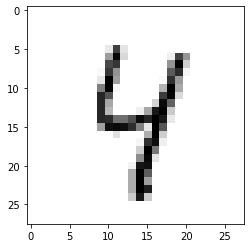

It is six with 100.0000% certainty


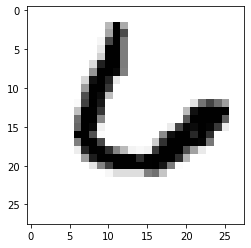

It is seven with 100.0000% certainty


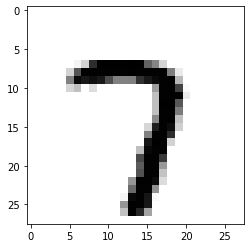

It is six with 88.5770% certainty


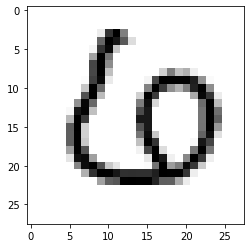

It is six with 100.0000% certainty


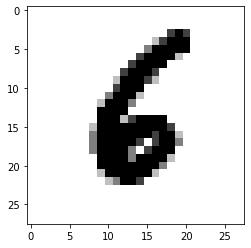

It is six with 99.9693% certainty


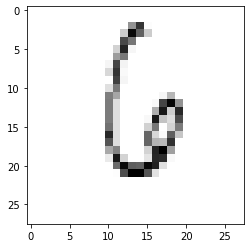

It is five with 100.0000% certainty


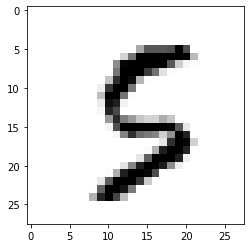

It is four with 100.0000% certainty


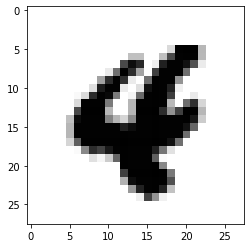

It is four with 99.8259% certainty


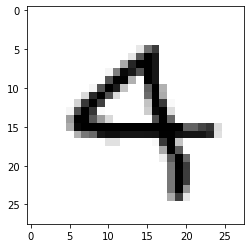

It is seven with 100.0000% certainty


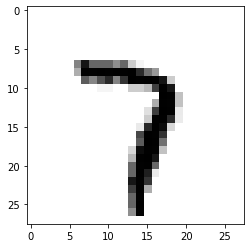

In [229]:
labels = ['zero','one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight',  'nine']
for i in range(10):
    element = test_data[random.randint(0,5000)][0]
    tensor_image = element.view((28,28))
    plt.imshow(tensor_image, cmap = plt.cm.gray_r)

    prediction = F.softmax(simplenet(element), dim=1)
    prediction_l = prediction.argmax()
    print('It is {} with {:.4f}% certainty'.format(labels[prediction_l], prediction.max()*100))
    plt.show()